In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import sys  
!{sys.executable} -m pip install contractions
!pip install pyLDAvis


  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.4
    Uninstalling numpy-1.22.4:
      Successfully uninstalled numpy-1.22.4
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.24.3 which is incompatible.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.24.3 which is incompatible.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 2.0.1 which is incompatible.


# Imports


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import pandas as pd
import re
import numpy as np
from nltk import word_tokenize, pos_tag

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Cargar y preparar los datos


En primer lugar, cargamos los datos. Esta vez vamos a descargarlos de un usuario de github que ha compartido el típico dataset de "20newsGroups" en su cuenta

In [ ]:
dataset =pd.read_json("https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json")

In [ ]:
dataset

,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space
...,...,...,...
11309,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
11310,From: ebodin@pearl.tufts.edu\nSubject: Screen ...,4,comp.sys.mac.hardware
11311,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
11312,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


Se observa un  texto muy "sucio" que vamos a tener que "limpiar"

Vamos a comprobar el tamaño del dataset:

In [ ]:
print("Tenemos un conjunto de {} documentos".format(dataset.shape[0]))

Tenemos un conjunto de 11314 documentos


Despues, quitaremos las filsa con algún valor vacío (NA) y quitaremos los duplicados.

In [ ]:
print("Existen {} reviews duplicadas".format(np.sum(dataset.duplicated(subset=["content"]))))
# Quitaremos esos duplicados
dataset = dataset.drop_duplicates()
print("Despues de quitar duplicados tenemos un conjunto de {} noticias".format(dataset.shape[0]))

Existen 0 reviews duplicadas
Despues de quitar duplicados tenemos un conjunto de 11314 noticias


Observamos que el corpus está sin preprocesar. Hay correos electrónicos, símbolos de retorno de carro ("\n")... 

# Preprocesado

## Normalización

Vamos a transformar los datos. Comenzaremos trabajando con los componentes que "ensucian" el corpus: los correos electrónicos, presencia de "\n", comillas...

In [ ]:
# Load the regular expression library
import re
import string
# Quita los emails presententes en un string (toma todos los string desde un espacio hasta la @ y todo lo que hay desde la @ hasta un espacio y lo sustituye por un "")
dataset['text_processed'] = dataset['content'].apply(lambda x: re.sub('\S*@\S*\s?', '', x))
# sustituir el \n
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: re.sub('\n', ' ', x))
# Quitar/eliminar las comillas
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: re.sub('\'', ' ', x))
# Convertir a lowercase
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: x.lower())
# Eliminar puntuación
dataset['text_processed'] = dataset['text_processed'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
dataset['text_processed']


0        from where s my thing subject what car is this...
1        from guy kuo subject si clock poll  final call...
2        from thomas e willis subject pb questions orga...
3        from joe green subject re weitek p9000  organi...
4        from jonathan mcdowell subject re shuttle laun...
                               ...                        
11309    from jim zisfein  subject re migraines and sca...
11310    from subject screen death mac plus512 lines 22...
11311    from will estes subject mounting cpu cooler in...
11312    from steven collins subject re sphere from 4 p...
11313    from kevin j gunning subject stolen cbr900rr o...
Name: text_processed, Length: 11314, dtype: object

El dataset es muy grande como para hacer las operaciones que queremos hacer durante la clase de forma rápida. Vamos a quedarnos con sólo una muestra.

In [ ]:
dataset2 = dataset.sample(700)

¿De qué ira el dataset? Una opción es hacer una wordcloud a partir de los datos anteriores. Esto se hace con la librería WordCloud.

Toma como entrada una frase que agrupa todos las frases del corpus, y genera el gráfico.

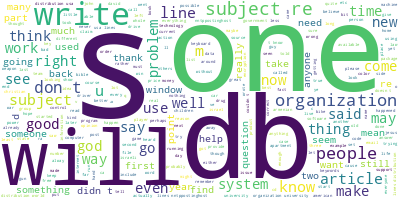

In [ ]:
from wordcloud import WordCloud
# Une las frases
long_string = ','.join(list(dataset2['text_processed'].values))
# Genera un objecto WordCloud 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=0, contour_color='steelblue')
# Genera el wordcloud
wordcloud.generate(long_string)
# Visualizalo en una imagen
wordcloud.to_image()

Se observan muchas stopwords como "re" o el auxiliar "will". También las palabras well, even... Que no proporcionan información. Vemos muchas frases a las que se les podría aplicar lematización... Es el momento de usar spacy!

In [ ]:
#!python -m spacy download en_core_web_sm
#!python -m spacy link en_core_web_sm en
#import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
import string
import spacy
punctuations = string.punctuation
nlp = spacy.load("en_core_web_sm")
stop_words = stopwords.words('english')

def spacy_tokenizer(sentence):
    mytokens = nlp(sentence)

    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    return mytokens

Procesemos las frases con esa función:

In [ ]:
data_words = list()
for i in dataset2["text_processed"].tolist():
  data_words.append(spacy_tokenizer(i))

In [ ]:
data_words[1]

['william',
 'daniel',
 'vaughan',
 'subject',
 'silly',
 'question',
 'xtianity',
 'line',
 '9',
 'organization',
 'university',
 'utah',
 'computer',
 'center',
 'article',
 'peter',
 'walker',
 'write',
 'peter',
 'walker',
 'subject',
 'silly',
 'question',
 'xtianity',
 'date',
 'mon',
 '12',
 'apr',
 '1993',
 '070633',
 'gmt',
 'article',
 'andrew',
 'tong',
 'write']

## Transformación

Para preprocesar datos de gensim utilizamos las funciones específicas con las que cuenta. 
Podemos utilizar el método `Phrases` 

In [ ]:
import gensim
# Construimos los modelos de bigramas y trigramas con gensim
# No devuelve trigramas o bigtamas en si mismos, si no que asocia palabras
# que aparecen juntas en mltitud de ocasiones
bigram = gensim.models.Phrases(data_words, min_count=10, threshold=100) # higher threshold fewer phrases.

# Con esto todo va más rápido, pero ya no pueden modificarse lo anterior
# https://www.kite.com/python/docs/gensim.models.phrases.Phraser
# The goal of this class is to cut down memory consumption of `Phrases`, by discarding model state
# not strictly needed for the bigram detection task.
# Use this instead of `Phrases` if you do not need to update the bigram statistics with new documents any more.
bigram_mod = gensim.models.phrases.Phraser(bigram)

In [ ]:
bigram_mod

*Si* miramos los resultados de acontinuación, lo que hacen estas librerías es generar bigramas a partir de la similitud que tienen las palabras en un espacio vectorial (utiliza word2vec por detrás). 

Por ejemplo, los tokens "New" "York" son unidos en el proceso anterior a "New_York".  Algo similar ocurre con "computer_science". Basicamente la idea de los brigramas en gensim es la de agrupar palabras que generalmente se usen juntas, y no incorporar más variables al sistema.

In [ ]:
[bigram_mod[i] for i in data_words]

In [ ]:
bigram_mod[data_words[1]]

In [ ]:
type(bigram_mod)

gensim.models.phrases.FrozenPhrases

Ahora hay que aplicar los modelos a los datos. Para eso utilizamos las funciones que aparecen más abajo. 

ADemás, se ha incorporado la función filtra_tags, que permite coger tokens de una categoría específica. Muy util apra el topic_modeling

In [ ]:
# NLTK Stop words
# import nltk
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['day', 'hotel', 'room', 'great', 'night','staff','service'])
# Define functions for stopwords, bigrams, trigrams and lemmatization
# Antes "entrenamos" el generador de bigrams, ahora se generan realmente en nuestros textos
def make_bigrams(textos):
    return [bigram_mod[doc] for doc in textos]

# Función para eliminar cierto tipo de tags
def filtra_tags(textos, tags_permitidas=['NOUN', 'ADJ', 'VERB', 'ADV']):
    textos_out = []
    for sent in textos:
        # Juntal los "trigrams"
        doc = nlp(" ".join(sent)) 
        # Filtra por etiqueta y coge lemma (es algo redundante)
        textos_out.append([token.text for token in doc if token.pos_ in tags_permitidas])
    return textos_out

Vamos a aplicar esas funciones:

In [ ]:
import spacy
# Remove Stop Words
#data_words_nostops = remove_stopwords(data_words)
# Crear Bigrams
data_words_bigrams = make_bigrams(data_words)

# Desabilitamos el "NER" y el "Parser" que no lo vamos a usar
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
#  Filtrar por categoría gramatical 
data_pos = filtra_tags(data_words_bigrams, tags_permitidas=['NOUN','ADJ','ADV'])

In [ ]:
print("Numero tokens antes de filtrar: {} tokens".format(len(data_words_bigrams[2])))
print("Numero tokens despues de filtrar: {} tokens".format(len(data_pos[2])))

Numero tokens antes de filtrar: 53 tokens
Numero tokens despues de filtrar: 18 tokens


In [ ]:
len(data_pos)

700

Despues de ese procesado tenemos un conjunto de 1000 documentos procesados y preparados para introudcir a un modelo de topic modeling

# Entramiento y validación

En primer lugar generamos un diccionario utilizando los objetos de Gensim. Ese diccionario contiene un método "doc2bow" que transforma el texto a vectores comprensibes por el modelo LDA.

In [ ]:
import gensim.corpora as corpora
# Creamos diccionario de términos 
id2word = corpora.Dictionary(data_pos)
print(id2word)

Dictionary<10998 unique tokens: ['ability', 'abroad', 'access', 'accommodate', 'activity']...>


In [ ]:
# Asignamos a la variable texts nuestro corpus
texts = data_pos
# Transformamos nuestro corpus limpio a Bag of Words. 
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus)

[[(0, 2), (1, 2), (2, 9), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 7), (9, 1), (10, 1), (11, 7), (12, 5), (13, 2), (14, 2), (15, 1), (16, 1), (17, 7), (18, 2), (19, 1), (20, 1), (21, 3), (22, 3), (23, 4), (24, 2), (25, 1), (26, 2), (27, 1), (28, 1), (29, 1), (30, 3), (31, 3), (32, 1), (33, 2), (34, 1), (35, 5), (36, 3), (37, 1), (38, 10), (39, 2), (40, 1), (41, 4), (42, 1), (43, 4), (44, 3), (45, 3), (46, 1), (47, 1), (48, 2), (49, 1), (50, 1), (51, 1), (52, 1), (53, 1), (54, 2), (55, 1), (56, 1), (57, 6), (58, 1), (59, 2), (60, 1), (61, 1), (62, 4), (63, 1), (64, 1), (65, 1), (66, 3), (67, 1), (68, 4), (69, 1), (70, 1), (71, 1), (72, 2), (73, 1), (74, 18), (75, 1), (76, 2), (77, 1), (78, 1), (79, 2), (80, 1), (81, 1), (82, 3), (83, 1), (84, 1), (85, 3), (86, 2), (87, 1), (88, 1), (89, 1), (90, 2), (91, 1), (92, 1), (93, 1), (94, 1), (95, 28), (96, 1), (97, 1), (98, 1), (99, 2), (100, 3), (101, 1), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 1), (108, 1), (109, 2), (110,

Los modelos LDA necesitaban además de los vectores de entrada, un número de "topics" para ser entrenados. 
Como no sabemos a priori cuantos hay, creamos la función "calculo_valor_coherencia" que a partir dle corpus, el diccionario y otros valores calcula un modelo lda, calcula la coherencia entre sus topics y la devuelve

In [ ]:
# supporting function
def calculo_valor_coherencia(corpus, dictionary, k, a, b):
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_pos, dictionary=dictionary, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [ ]:
from tqdm.autonotebook import tqdm
tqdm.pandas()

<ipython-input-21-c6814585a5e3>:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Vamos a calcular la coherencia suponiendo distintos números de topics. Por ejemplo de 1 a 22 en saltos de 2.

In [ ]:
import numpy as np
import tqdm
grid = {}
# Topics range
min_topics = 2
max_topics = 22
step_size = 2
topics_range = range(min_topics, max_topics, step_size)
# Alpha
alpha = 0.01
# Beta
beta = 0.9
# Validation sets
num_of_docs = len(corpus)
corpus_sets = corpus
corpus_title = '100% Corpus'
model_results = {'Topics': [],
                 'Alpha': [],
                 'Beta': [],
                 'Coherence': []}

# Vamos a esperar mucho....
if 1 == 1:
    pbar = tqdm.tqdm()
    # Itera a lo largo del range de los topics
    for k in topics_range:
      # Calculamos coherencia para esos topics
      cv = calculo_valor_coherencia(corpus=corpus, dictionary=id2word,
                                    k=k, a=alpha, b=beta)
      # Guardamos los datos
      #model_results['Validation_Set'].append(corpus_title[i])
      model_results['Topics'].append(k)
      model_results['Alpha'].append(alpha)
      model_results['Beta'].append(beta)
      model_results['Coherence'].append(cv)

      pbar.update(1)
    pbar.close()

10it [01:55, 11.54s/it]


In [ ]:
model_results


{'Topics': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'Alpha': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01],
 'Beta': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9],
 'Coherence': [0.3302163284222662,
  0.4435286118273799,
  0.4282351695798841,
  0.41265396044228086,
  0.4353565654207087,
  0.38960574647139695,
  0.3702852662525297,
  0.4712144180330473,
  0.47912398795431876,
  0.4546189883338105]}

Ploteamos el resultado y observamos que el máximo de cogerencia está en torno a 13 topics.

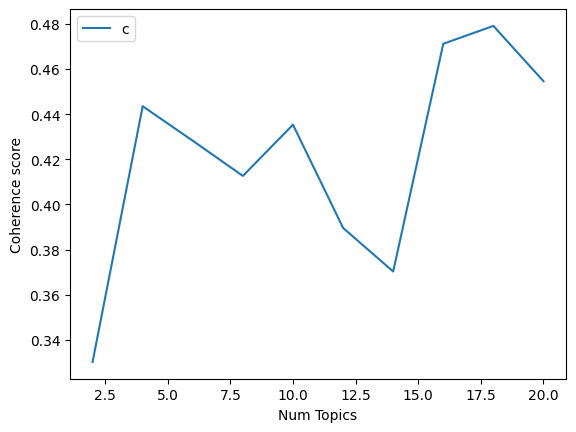

In [ ]:
# Show graph
import matplotlib.pyplot as plt
plt.plot(topics_range, model_results["Coherence"])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Entrenamos el modelo con el número de topics anteriormente calculado:

In [ ]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=12, 
                                      random_state=100,
                                      chunksize=100,
                                      passes=10,
                                      alpha=0.01,
                                      eta=0.9)

In [ ]:
model_topics = lda_model.show_topics(formatted=False)
print(lda_model.print_topics(num_words=3))

[(0, '0.002*"scsi2" + 0.001*"relay" + 0.001*"audio"'), (1, '0.002*"simms" + 0.002*"plastic" + 0.002*"tower"'), (2, '0.011*"line" + 0.007*"people" + 0.007*"article"'), (3, '0.001*"disease" + 0.001*"pen" + 0.001*"splitfire"'), (4, '0.005*"flyer" + 0.002*"leafs" + 0.001*"lindro"'), (5, '0.004*"g" + 0.002*"q" + 0.001*"part"'), (6, '0.004*"bit" + 0.003*"byte" + 0.002*"pop"'), (7, '0.004*"israeli" + 0.002*"arab" + 0.001*"lebanese"'), (8, '0.001*"30v" + 0.001*"rating" + 0.001*"ic"'), (9, '0.005*"key" + 0.004*"drug" + 0.004*"information"'), (10, '0.001*"peak" + 0.000*"neon" + 0.000*"player"'), (11, '0.001*"numlock" + 0.001*"envelop" + 0.001*"pfswrite"')]


In [ ]:
import pyLDAvis
import pyLDAvis.gensim 
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.184581 -0.002658       1        1  82.027372
9     -0.007225  0.043407       2        1   6.381326
6     -0.019846 -0.023076       3        1   4.079089
5     -0.029278 -0.004322       4        1   1.849784
1     -0.018149 -0.002781       5        1   1.297794
3     -0.017348 -0.002211       6        1   0.999720
4     -0.016341 -0.003183       7        1   0.835239
0     -0.015112 -0.001788       8        1   0.619946
7     -0.015266 -0.000477       9        1   0.579747
10    -0.015309 -0.000933      10        1   0.531822
11    -0.015212 -0.001009      11        1   0.452606
8     -0.015494 -0.000968      12        1   0.345555, topic_info=             Term       Freq      Total Category  logprob  loglift
621           bit  71.000000  71.000000  Default  30.0000  30.0000
141   information  60.000000  60.000000  Default  29.0000  29.0000
121    government  89.000000  89.000000  Default  28.0000  28.0000
147           key  42.000000  42.000000  Default  27.0000  27.0000
3862     armenian  61.000000  61.000000  Default  26.0000  26.0000
...           ...        ...        ...      ...      ...      ...
160          link   0.074643   7.394747  Topic12  -7.8817   1.0720
6135      maximum   0.071697   7.128907  Topic12  -7.9220   1.0683
7159      bicycle   0.049785   3.398990  Topic12  -8.2867   1.4442
4709    candidate   0.057706   5.755280  Topic12  -8.1390   1.0653
2153       league   0.064424  10.320531  Topic12  -8.0289   0.5914

[546 rows x 6 columns], token_table=      Topic      Freq                  Term
term                                       
7783      1  0.623630                   10w
7244      1  0.603385                   13p
7245      1  0.603385  144t3ss1wwtuw1wt4711
5223      1  0.644834                    2b
7784      1  0.599148                   30v
...     ...       ...                   ...
3425      2  0.574715                     z
8533      1  0.517188                  zone
3426      1  0.602548                  zorg
9310      1  0.217696           zoroastrian
9310      3  0.653089           zoroastrian

[683 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 10, 7, 6, 2, 4, 5, 1, 8, 11, 12, 9])

Una vez lo hemos validado, podemos asociar topics a cada uno de los documentos.

Utilizando el método get_document_topics() sobre el texto del corpus que queramos podemos detectar la composición de temas que tiene cada documento:

In [ ]:
lda_model.get_document_topics(corpus[0])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.9982826)]

Podríamos ver la contribución de una palabra específica a cada uno de los topics con get_term_topics:

In [ ]:
lda_model.get_term_topics("people", minimum_probability=0.0001) #Get the most relevant topics to the given word.



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(1, 0.0021952968), (7, 0.0006487054), (8, 0.008188355)]